<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Baseline Model</a></span><ul class="toc-item"><li><span><a href="#Model-Validation" data-toc-modified-id="Model-Validation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Model Validation</a></span></li><li><span><a href="#Trying-other-metrics-to-judge-the-model." data-toc-modified-id="Trying-other-metrics-to-judge-the-model.-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Trying other metrics to judge the model.</a></span></li></ul></li><li><span><a href="#Handling-Class-Imbalance" data-toc-modified-id="Handling-Class-Imbalance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Handling Class Imbalance</a></span><ul class="toc-item"><li><span><a href="#Method-1:-Weighted-Model" data-toc-modified-id="Method-1:-Weighted-Model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Method 1: Weighted Model</a></span></li><li><span><a href="#Method-2:-Resampling(Oversampling-the-minority-class)" data-toc-modified-id="Method-2:-Resampling(Oversampling-the-minority-class)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Method 2: Resampling(Oversampling the minority class)</a></span></li><li><span><a href="#Method-3:-Resampling(Undersampling-the-majority-class)" data-toc-modified-id="Method-3:-Resampling(Undersampling-the-majority-class)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Method 3: Resampling(Undersampling the majority class)</a></span></li></ul></li></ul></div>

In [1]:
import configuration as config
import utilities as utils
import DataLoader as dl
import ModelGenerator as mg
import Train
import ModelValidation as mv
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import math

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
credit_card_data = utils.get_data(config.INPUT_FILE_PATH)

Data loaded from input CSV
Shape of input file:(284807, 31)


In [4]:
no_fraud, fraud = credit_card_data.Class.value_counts()
print(f'No Fraud {no_fraud}')
print(f'Fraud {fraud}')
print(f'Fraud proportion {round(utils.percentage(fraud, no_fraud + fraud), 2)}%')

No Fraud 284315
Fraud 492
Fraud proportion 0.17%


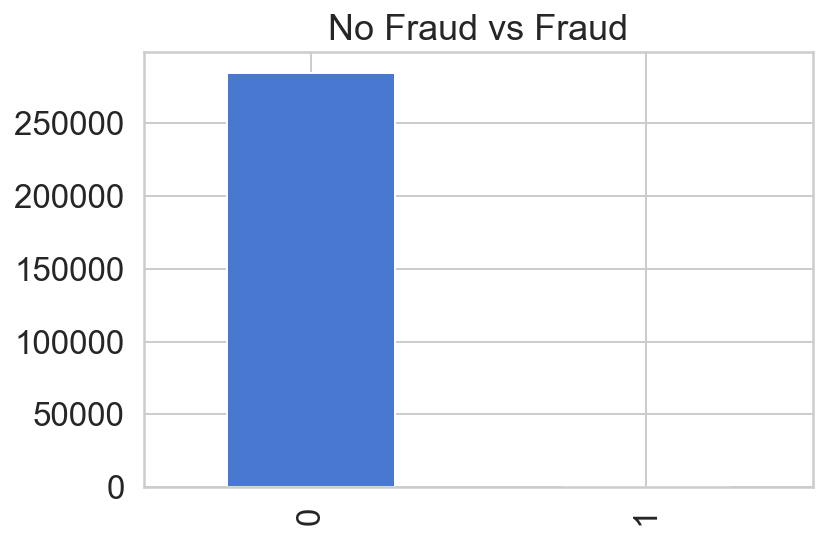

In [5]:
utils.plot_class_balance(credit_card_data, 'Class', title="No Fraud vs Fraud");

In [6]:
data = dl.DataGenerator(credit_card_data, split=0.05)

## Baseline Model

In [7]:
model = mg.build_model(data.X_train)

In [8]:
history = Train.Trainer(model, data).history

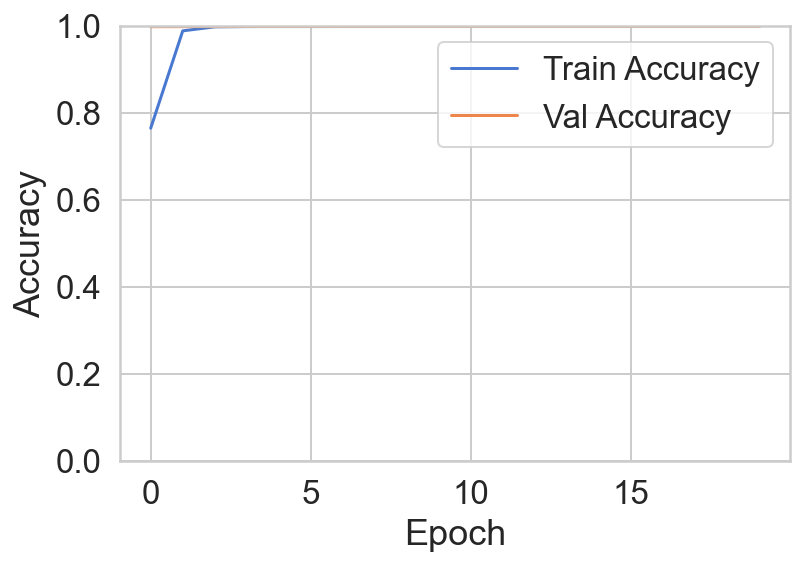

In [9]:
mv.plot_accuracy(history)

In [10]:
model.evaluate(data.X_test, data.y_test, batch_size=config.BATCH_SIZE)

14241/14241 [==============================] - 0s 2us/sample - loss: 0.0111 - accuracy: 0.9985


[0.011079446155709738, 0.9985254]

In [11]:
def awesome_model_predict(features):
  return np.full((features.shape[0], ), 0)

In [12]:
y_pred = awesome_model_predict(data.X_test)

In [13]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred, data.y_test)

0.9985253844533389

### Model Validation



In [14]:
model_pred = model.predict(data.X_test, batch_size=config.BATCH_SIZE)

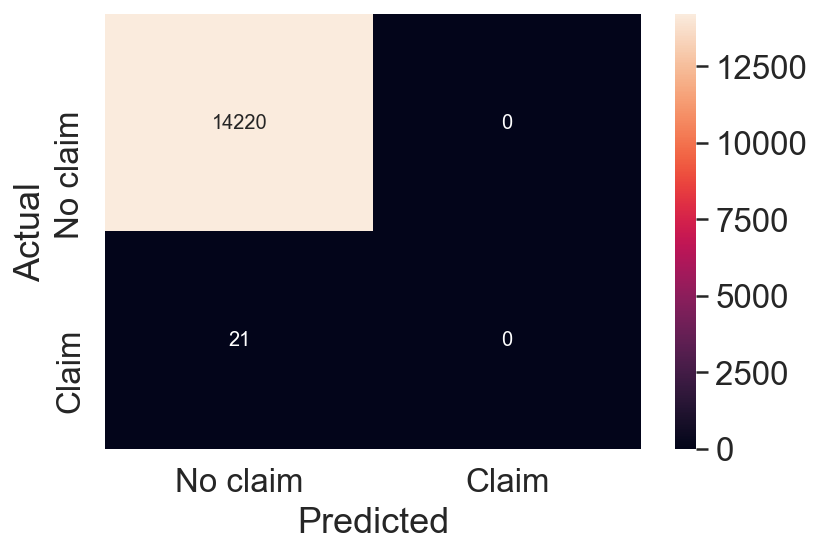

In [15]:
mv.plot_cm(data.y_test, model_pred)

### Trying other metrics to judge the model.

In [16]:
model_metric = mg.build_model(data.X_train, metrics=config.METRICS)

In [17]:
history_metric = Train.Trainer(model_metric, data).history

In [18]:
evaluation_results = model_metric.evaluate(data.X_test, data.y_test, batch_size=config.BATCH_SIZE, verbose=0)
y_pred = model_metric.predict(data.X_test, batch_size=config.BATCH_SIZE)
mv.print_metrics(model_metric, evaluation_results, y_pred, data.y_test)

loss :  0.011018906157991153
tp :  0.0
fp :  0.0
tn :  14220.0
fn :  21.0
accuracy :  0.9985254
precision :  0.0
recall :  0.0
auc :  0.49992967
f1 score: 0.0


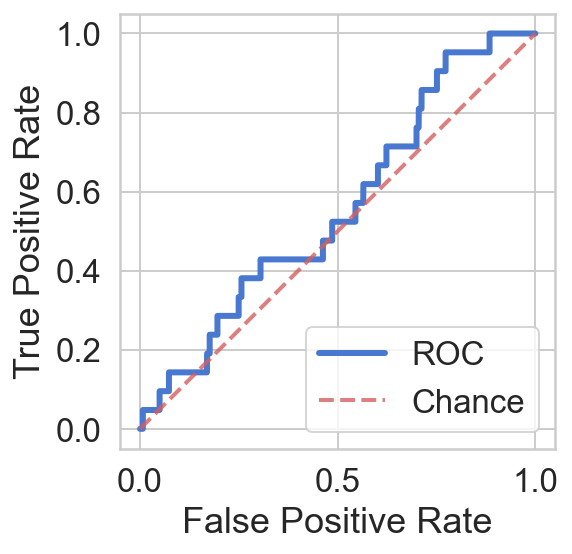

In [19]:
mv.plot_roc(data.y_test, model_pred)

Clearly base model doesn't do justice to the problem. Even a model predicting all the records as 'No Fraud' will give higher accuracy. This can be seen in precision, recall and F1 score


## Handling Class Imbalance

### Method 1: Weighted Model

In [20]:
no_fraud_count, fraud_count = np.bincount(credit_card_data[config.LABEL_COLUMN])
total_count = len(credit_card_data[config.LABEL_COLUMN])

In [21]:
weight_no_fraud = (1 / no_fraud_count) * (total_count) / 2.0
weight_fraud = (1 / fraud_count) * (total_count) / 2.0

class_weights = {0: weight_no_fraud, 1: weight_fraud}

In [22]:
model_weights = mg.build_model(data.X_train, metrics=config.METRICS)

In [23]:
history_wieghts = Train.Trainer(model_weights,data, class_weights, 1)

In [24]:
model_pred = model_weights.predict(data.X_test, batch_size=config.BATCH_SIZE)

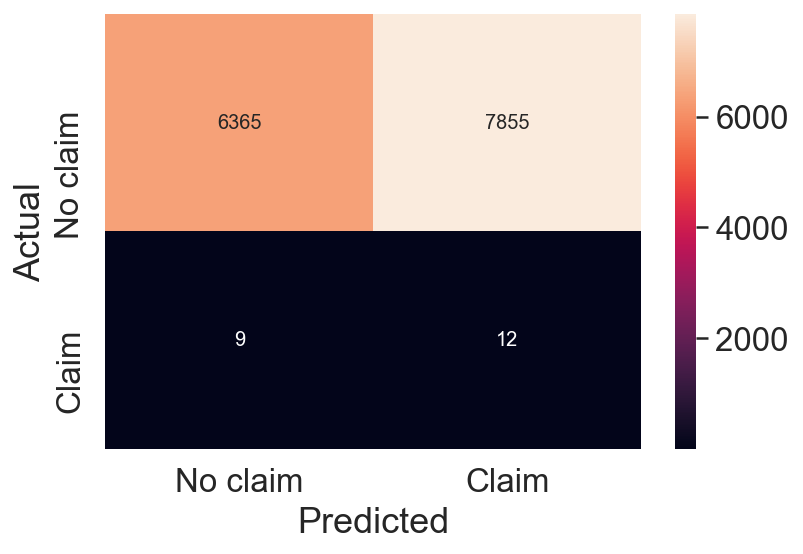

In [25]:
mv.plot_cm(data.y_test, model_pred)

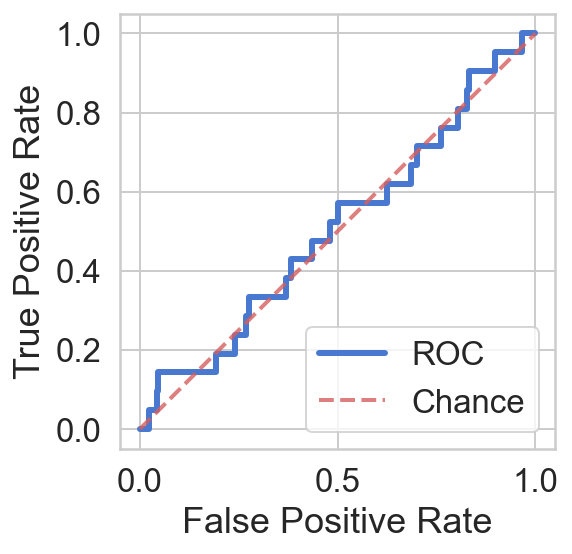

In [26]:
mv.plot_roc(data.y_test, model_pred)

In [27]:
evaluation_results = model_weights.evaluate(data.X_test, data.y_test, batch_size=config.BATCH_SIZE, verbose=0)
y_pred = model_weights.predict(data.X_test, batch_size=config.BATCH_SIZE)
mv.print_metrics(model_weights, evaluation_results, y_pred, data.y_test)

loss :  0.7311652220707664
tp :  12.0
fp :  7855.0
tn :  6365.0
fn :  9.0
accuracy :  0.44779158
precision :  0.0015253591
recall :  0.5714286
auc :  0.5073321
f1 score: 0.0030425963488843817


### Method 2: Resampling(Oversampling the minority class)

In [28]:
X = pd.concat([data.X_train, data.y_train], axis=1)

no_fraud = X[X.Class == 0]
fraud = X[X.Class == 1]

In [29]:
X.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [30]:
from sklearn.utils import resample

fraud_upsampled = resample(fraud,
                          replace=True, 
                          n_samples=len(no_fraud),
                          random_state=config.RANDOM_SEED)

In [31]:
upsampled = pd.concat([no_fraud, fraud_upsampled])

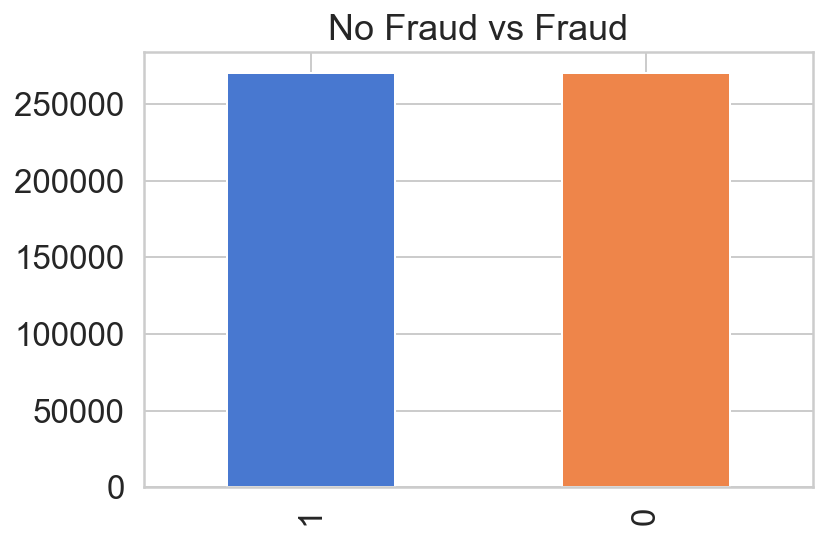

In [32]:
upsampled.Class.value_counts().plot(kind="bar", title="No Fraud vs Fraud");

In [33]:
model_oversampling = mg.build_model(upsampled.drop([config.LABEL_COLUMN], axis = 1), metrics=config.METRICS)

In [34]:
history_oversampling = Train.Trainer(model_oversampling, data).history

In [37]:
model_pred = model_oversampling.predict(data.X_test, batch_size=config.BATCH_SIZE)

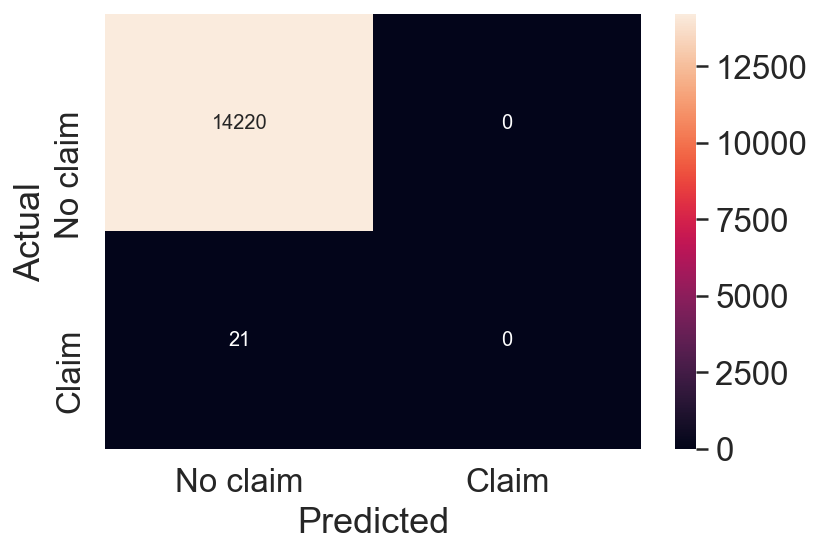

In [38]:
mv.plot_cm(data.y_test, model_pred)

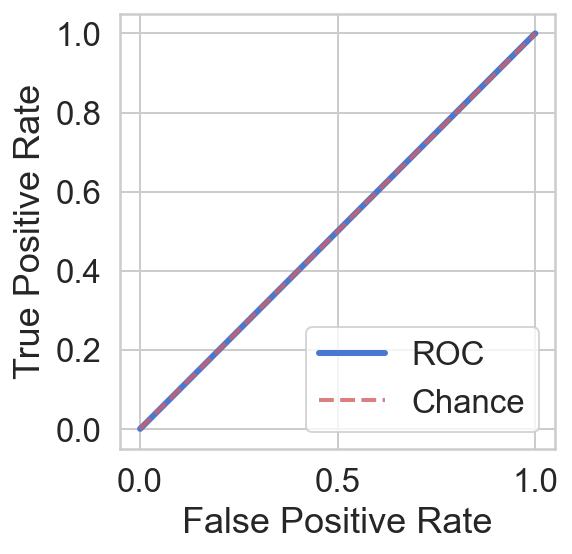

In [39]:
mv.plot_roc(data.y_test, model_pred)

In [40]:
evaluation_results = model_oversampling.evaluate(data.X_test, data.y_test, batch_size=config.BATCH_SIZE, verbose=0)
y_pred = model_oversampling.predict(data.X_test, batch_size=config.BATCH_SIZE)
mv.print_metrics(model_oversampling, evaluation_results, y_pred, data.y_test)

loss :  0.01108676549182604
tp :  0.0
fp :  0.0
tn :  14220.0
fn :  21.0
accuracy :  0.9985254
precision :  0.0
recall :  0.0
auc :  0.49996483
f1 score: 0.0


### Method 3: Resampling(Undersampling the majority class)